# 二十一点 Blackjack-v1

In [1]:
%matplotlib inline
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import gym

### 环境使用

In [2]:
env = gym.make("Blackjack-v1")
env.seed(0)
print('观察空间 = {}'.format(env.observation_space))
print('动作空间 = {}'.format(env.action_space))
print('动作数量 = {}'.format(env.action_space.n))

观察空间 = Tuple(Discrete(32), Discrete(11), Discrete(2))
动作空间 = Discrete(2)
动作数量 = 2


### 同策回合更新
回合更新预测

In [3]:
def ob2state(observation):
    return observation[0], observation[1], int(observation[2])

def evaluate_action_monte_carlo(env, policy, episode_num=500000):
    q = np.zeros_like(policy)
    c = np.zeros_like(policy)
    for _ in range(episode_num):
        # 玩一回合
        state_actions = []
        observation = env.reset()
        while True:
            state = ob2state(observation)
            action = np.random.choice(env.action_space.n, p=policy[state])
            state_actions.append((state, action))
            observation, reward, done, _ = env.step(action)
            if done:
                break # 回合结束
        g = reward # 回报
        for state, action in state_actions:
            c[state][action] += 1.
            q[state][action] += (g - q[state][action]) / c[state][action]
    return q

In [4]:
policy = np.zeros((22, 11, 2, 2))
policy[20:, :, :, 0] = 1 # >= 20 时收手
policy[:20, :, :, 1] = 1 # < 20 时继续

q = evaluate_action_monte_carlo(env, policy) # 动作价值
v = (q * policy).sum(axis=-1) # 状态价值

In [5]:
def plot(data):
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
    titles = ['without ace', 'with ace']
    have_aces = [0, 1]
    extent = [12, 22, 1, 11]
    for title, have_ace, axis in zip(titles, have_aces, axes):
        dat = data[extent[0]:extent[1], extent[2]:extent[3], have_ace].T
        axis.imshow(dat, extent=extent, origin='lower')
        axis.set_xlabel('player sum')
        axis.set_ylabel('dealer showing')
        axis.set_title(title)

In [6]:
def play_once(env):
    total_reward = 0
    observation = env.reset()
    print('观测 = {}'.format(observation))
    while True:
        print('玩家 = {}, 庄家 = {}'.format(env.player, env.dealer))
        action = np.random.choice(env.action_space.n)
        print('动作 = {}'.format(action))
        observation, reward, done, _ = env.step(action)
        print('观测 = {}, 奖励 = {}, 结束指示 = {}'.format(
                observation, reward, done))
        total_reward += reward
        if done:
            return total_reward # 回合结束
    
print("随机策略 奖励：{}".format(play_once(env)))

观测 = (18, 10, False)
玩家 = [8, 10], 庄家 = [10, 1]
动作 = 1
观测 = (26, 10, False), 奖励 = -1.0, 结束指示 = True
随机策略 奖励：-1.0


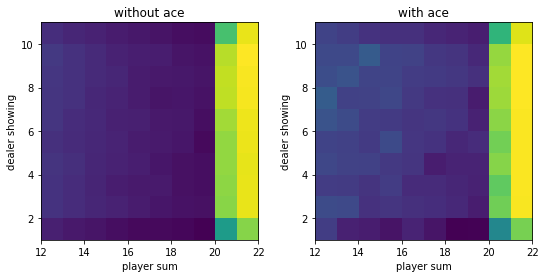

In [7]:
plot(v)

带起始探索的回合更新

In [8]:
def monte_carlo_with_exploring_start(env, episode_num=500000):
    policy = np.zeros((22, 11, 2, 2))
    policy[:, :, :, 1] = 1.
    q = np.zeros_like(policy)
    c = np.zeros_like(policy)
    for _ in range(episode_num):
        # 随机选择起始状态和起始动作
        state = (np.random.randint(12, 22),
                 np.random.randint(1, 11),
                 np.random.randint(2))
        action = np.random.randint(2)
        # 玩一回合
        env.reset()
        if state[2]: # 有A
            env.player = [1, state[0] - 11]
        else: # 没有A
            if state[0] == 21:
                env.player = [10, 9, 2]
            else:
                env.player = [10, state[0] - 10]
        env.dealer[0] = state[1]
        state_actions = []
        while True:
            state_actions.append((state, action))
            observation, reward, done, _ = env.step(action)
            if done:
                break # 回合结束
            state = ob2state(observation)
            action = np.random.choice(env.action_space.n, p=policy[state])
        g = reward # 回报
        for state, action in state_actions:
            c[state][action] += 1.
            q[state][action] += (g - q[state][action]) / c[state][action]
            a = q[state].argmax()
            policy[state] = 0.
            policy[state][a] = 1.
    return policy, q

In [9]:
policy, q = monte_carlo_with_exploring_start(env)
v = q.max(axis=-1)

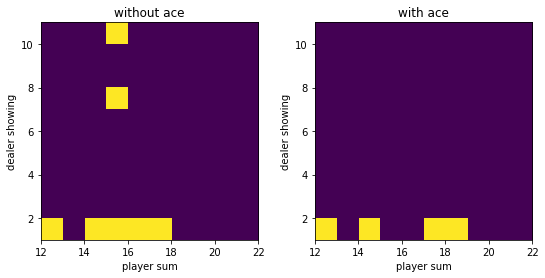

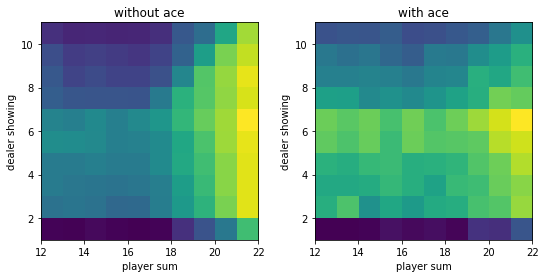

In [10]:
plot(policy.argmax(-1))
plot(v)

基于柔性策略的回合更新

In [11]:
def monte_carlo_with_soft(env, episode_num=500000, epsilon=0.1):
    policy = np.ones((22, 11, 2, 2)) * 0.5 # 柔性策略
    q = np.zeros_like(policy)
    c = np.zeros_like(policy)
    for _ in range(episode_num):
        # 玩一回合
        state_actions = []
        observation = env.reset()
        while True:
            state = ob2state(observation)
            action = np.random.choice(env.action_space.n, p=policy[state])
            state_actions.append((state, action))
            observation, reward, done, _ = env.step(action)
            if done:
                break # 回合结束
        g = reward # 回报
        for state, action in state_actions:
            c[state][action] += 1.
            q[state][action] += (g - q[state][action]) / c[state][action]
            # 更新策略为柔性策略
            a = q[state].argmax()
            policy[state] = epsilon / 2.
            policy[state][a] += (1. - epsilon)
    return policy, q

In [12]:
policy, q = monte_carlo_with_soft(env)
v = q.max(axis=-1)

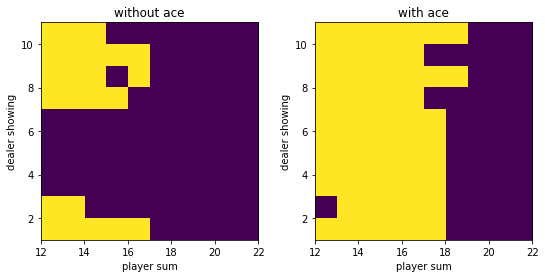

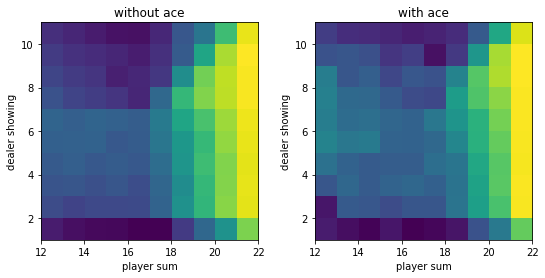

In [13]:
plot(policy.argmax(-1))
plot(v)

### 异策回合更新
重要性采样策略评估

In [14]:
def evaluate_monte_carlo_importance_sample(env, policy, behavior_policy,
        episode_num=500000):
    q = np.zeros_like(policy)
    c = np.zeros_like(policy)
    for _ in range(episode_num):
        # 用行为策略玩一回合
        state_actions = []
        observation = env.reset()
        while True:
            state = ob2state(observation)
            action = np.random.choice(env.action_space.n,
                    p=behavior_policy[state])
            state_actions.append((state, action))
            observation, reward, done, _ = env.step(action)
            if done:
                break # 玩好了
        g = reward # 回报
        rho = 1. # 重要性采样比率
        for state, action in reversed(state_actions):
            c[state][action] += rho
            q[state][action] += (rho / c[state][action] * (g - q[state][action]))
            rho *= (policy[state][action] / behavior_policy[state][action])
            if rho == 0:
                break # 提前终止
    return q

In [15]:
policy = np.zeros((22, 11, 2, 2))
policy[20:, :, :, 0] = 1 # >= 20 时收手
policy[:20, :, :, 1] = 1 # < 20 时继续
behavior_policy = np.ones_like(policy) * 0.5
q = evaluate_monte_carlo_importance_sample(env, policy, behavior_policy)
v = (q * policy).sum(axis=-1)

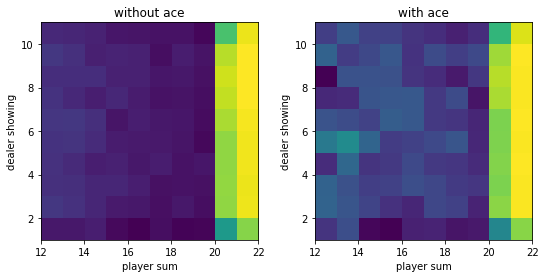

In [16]:
plot(v)

重要性采样回合更新

In [17]:
def monte_carlo_importance_sample(env, episode_num=500000):
    policy = np.zeros((22, 11, 2, 2))
    policy[:, :, :, 0] = 1.
    behavior_policy = np.ones_like(policy) * 0.5 # 柔性策略
    q = np.zeros_like(policy)
    c = np.zeros_like(policy)
    for _ in range(episode_num):
        # 用行为策略玩一回合
        state_actions = []
        observation = env.reset()
        while True:
            state = ob2state(observation)
            action = np.random.choice(env.action_space.n,
                    p=behavior_policy[state])
            state_actions.append((state, action))
            observation, reward, done, _ = env.step(action)
            if done:
                break # 玩好了
        g = reward # 回报
        rho = 1. # 重要性采样比率
        for state, action in reversed(state_actions):
            c[state][action] += rho
            q[state][action] += (rho / c[state][action] * (g - q[state][action]))
            # 策略改进
            a = q[state].argmax()
            policy[state] = 0.
            policy[state][a] = 1.
            if a != action: # 提前终止
                break
            rho /= behavior_policy[state][action]
    return policy, q

In [18]:
policy, q = monte_carlo_importance_sample(env)
v = q.max(axis=-1)

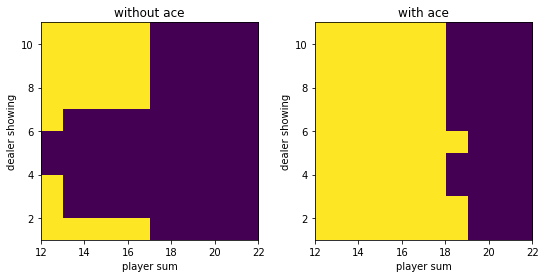

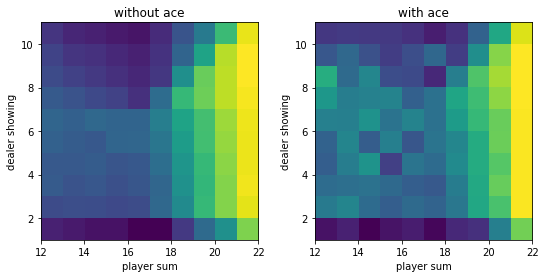

In [19]:
plot(policy.argmax(-1))
plot(v)